# Importing necessary libraries 

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller



# We're going to predict forecast for Poland

In [2]:
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

In [3]:
df = df[df['Country'] == 'Poland']

# Checking for missing values 

([<matplotlib.patches.Wedge at 0x24d272e8070>,
 [Text(-1.097243835778853, 0.077820079962112, 'Non NaN elements'),
  Text(1.3964921523093448, -0.09904377082085544, 'NaN elements')])

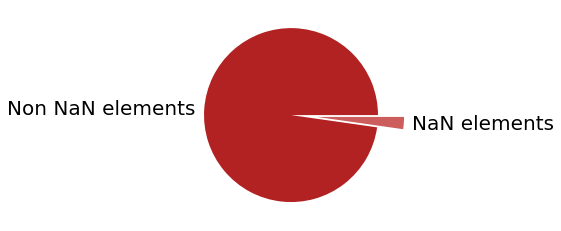

In [4]:
explodes = (0,0.3)
plt.pie(df.AverageTemperature.isna().value_counts(),explode=explodes,startangle=0,colors=['firebrick','indianred'],
   labels=['Non NaN elements','NaN elements'], textprops={'fontsize': 20})

# Since there aren't a lot of missing values, we can just drop them

In [5]:
df.dropna(inplace=True)

# We're going to convert dt column to datetime object and make a year column

In [6]:
df = df.reset_index()

In [7]:
df = df.drop(columns=['index'])

In [8]:
df.dt = pd.to_datetime(df.dt)

In [9]:
YEAR = []
for i in range(len(df)):
    YEAR.append(df.dt[i].year)

In [10]:
df['Year'] = YEAR


In [12]:
df = df[df['Year'] >= 1800]

In [13]:
df.reset_index(inplace=True)

In [14]:
df.set_index('Year', inplace=True)

In [15]:
df.drop('index', axis=1, inplace=True)

F:\Users\Klaudiuszek\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
df.drop('dt', axis=1, inplace=True)

In [17]:
df = df.groupby(df.index).mean()

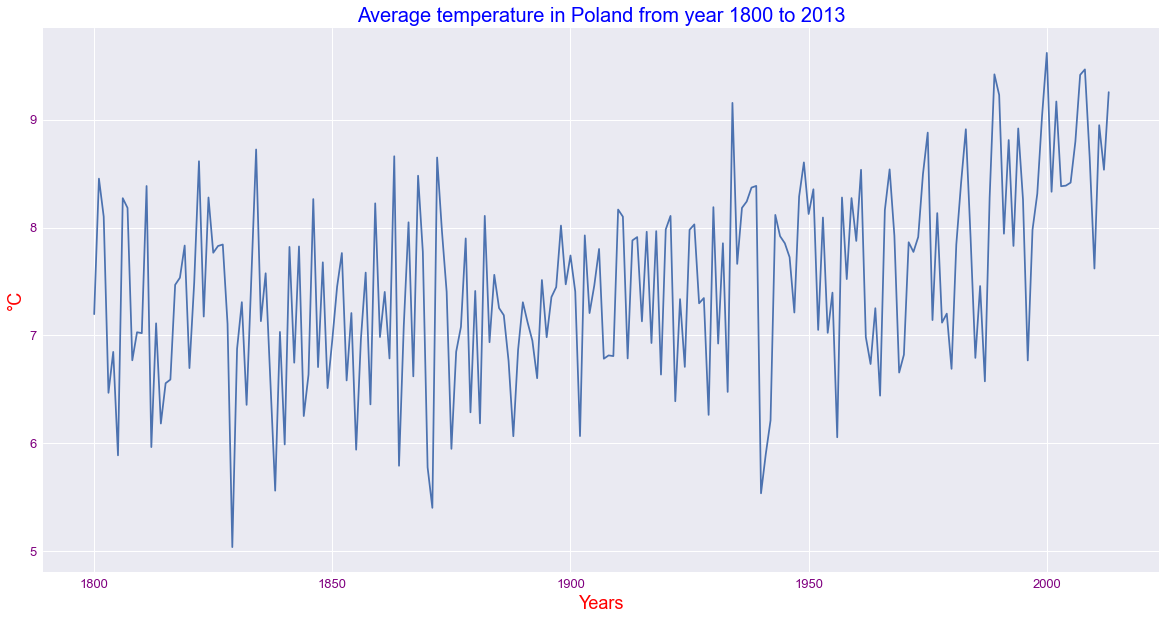

In [18]:
fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.ticklabel_format(style='plain')
plt.xlabel("Years", fontsize=18, color='red')
plt.ylabel("°C", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.title("Average temperature in Poland from year 1800 to 2013", fontsize=20, color='blue')

plt.plot(df['AverageTemperature'])

In [19]:
# ADF Test
result = adfuller(df.AverageTemperature, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 0.7805569749879145
n_lags: 0.9913157495297593
p-value: 0.9913157495297593
Critial Values:
   1%, -3.4638151713286316
Critial Values:
   5%, -2.876250632135043
Critial Values:
   10%, -2.574611347821651


## Our data is not-stationary

# We're going to use time 1990-2013 for prediction

In [20]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = 200
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

In [22]:
def evaluate_models(dataset, p_values, d_values, q_values):
	best_score, best_cfg = 1000000000, None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [28]:
p_values = [0, 1, 2, 3, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df.AverageTemperature.tolist(), p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.450
ARIMA(0, 0, 1) RMSE=1.303
ARIMA(0, 0, 2) RMSE=1.122
ARIMA(0, 1, 0) RMSE=0.760
ARIMA(0, 1, 1) RMSE=0.824
ARIMA(0, 1, 2) RMSE=0.819
ARIMA(0, 2, 0) RMSE=1.271
ARIMA(0, 2, 1) RMSE=0.764
ARIMA(0, 2, 2) RMSE=0.703
ARIMA(1, 0, 0) RMSE=1.226
ARIMA(1, 0, 1) RMSE=0.835
ARIMA(1, 1, 0) RMSE=0.701
ARIMA(1, 1, 1) RMSE=0.819
ARIMA(1, 1, 2) RMSE=0.827
ARIMA(1, 2, 0) RMSE=0.956
ARIMA(2, 0, 0) RMSE=1.096
ARIMA(2, 0, 1) RMSE=1.117
ARIMA(2, 1, 0) RMSE=0.706
ARIMA(2, 1, 1) RMSE=0.818
ARIMA(2, 2, 0) RMSE=0.911
ARIMA(3, 0, 0) RMSE=1.144
ARIMA(3, 0, 1) RMSE=1.140
ARIMA(3, 0, 2) RMSE=0.970
ARIMA(3, 1, 0) RMSE=0.717
ARIMA(3, 1, 1) RMSE=0.791
ARIMA(3, 2, 0) RMSE=0.947
ARIMA(4, 0, 0) RMSE=1.095
ARIMA(4, 0, 1) RMSE=0.813
ARIMA(4, 1, 0) RMSE=0.643
ARIMA(4, 1, 1) RMSE=0.773
ARIMA(4, 1, 2) RMSE=0.822
ARIMA(4, 2, 0) RMSE=0.872
ARIMA(6, 0, 0) RMSE=0.943
ARIMA(6, 0, 1) RMSE=0.795
ARIMA(6, 0, 2) RMSE=0.962
ARIMA(6, 1, 0) RMSE=0.614
ARIMA(6, 1, 1) RMSE=0.773
ARIMA(6, 1, 2) RMSE=0.784
ARIMA(6, 2, 

# We've found out that the model with p=6, d=2, q=1 is the best model. Now we can evaluate it, plot it and make predictions.

In [42]:
X = df.AverageTemperature.tolist()
size = 200
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(6, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"predicted: {yhat}, expected: {obs}")

rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse}")

predicted: [8.33019219], expected: 9.622166666666667
predicted: [8.63750502], expected: 8.333833333333333
predicted: [8.35801032], expected: 9.171166666666666
predicted: [8.32790577], expected: 8.385083333333334
predicted: [8.83701565], expected: 8.390500000000001
predicted: [8.75106014], expected: 8.4185
predicted: [8.85968231], expected: 8.799916666666666
predicted: [8.92222382], expected: 9.418083333333334
predicted: [8.89584741], expected: 9.469166666666666
predicted: [9.08582259], expected: 8.652916666666668
predicted: [8.8027039], expected: 7.621416666666666
predicted: [8.52051749], expected: 8.951666666666666
predicted: [8.80450636], expected: 8.53775
predicted: [9.0950696], expected: 9.257875
Test RMSE: 0.6083011662151951


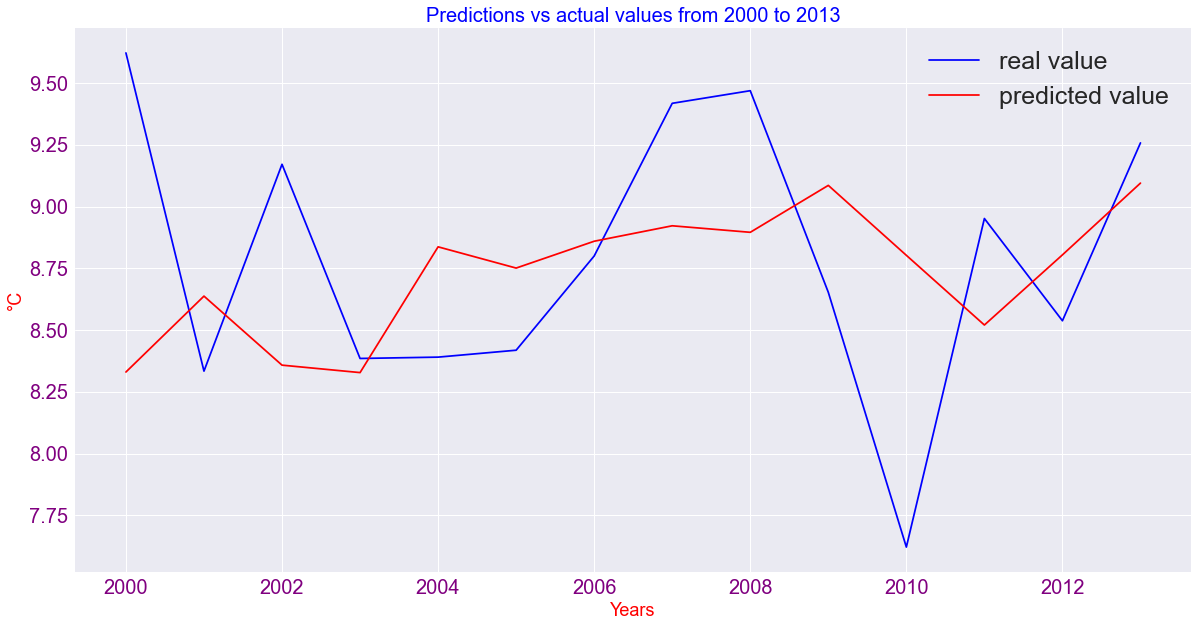

In [53]:
Years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.ticklabel_format(style='plain')
plt.xlabel("Years", fontsize=18, color='red')
plt.ylabel("°C", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=20)
plt.title("Predictions vs actual values from 2000 to 2013", fontsize=20, color='blue')
plt.plot(Years, test, color='blue', label='real value')
plt.plot(Years, predictions, color='red', label='predicted value')
plt.legend(prop={'size': 25})

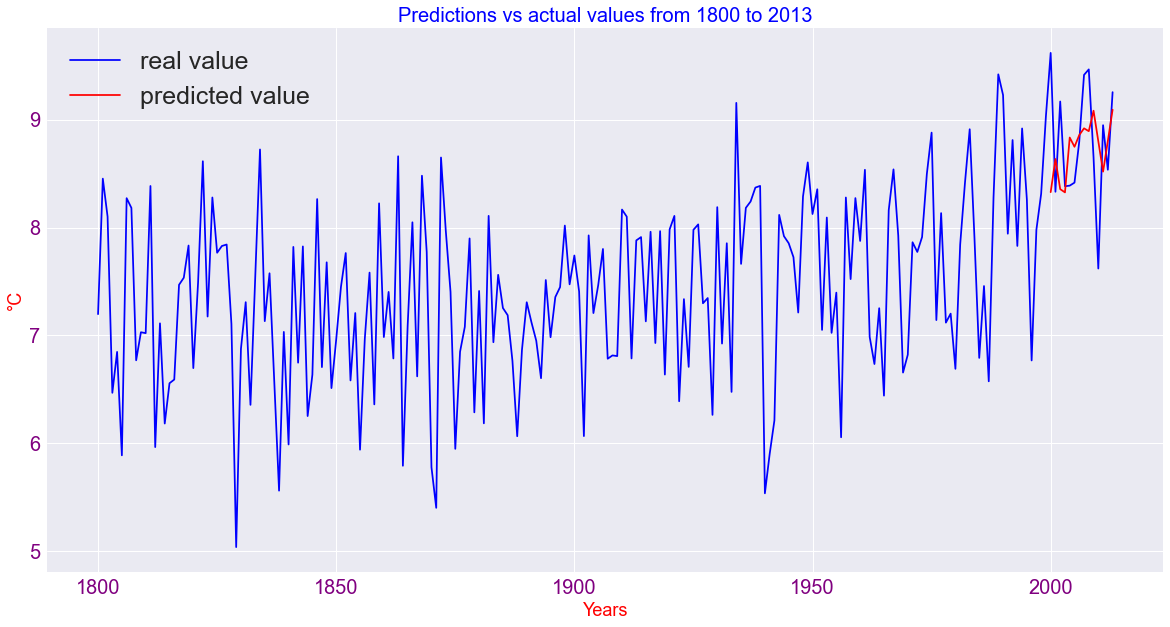

In [58]:
fig = plt.figure(figsize=(20, 10))
Years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
plt.style.use('seaborn')

plt.ticklabel_format(style='plain')
plt.xlabel("Years", fontsize=18, color='red')
plt.ylabel("°C", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=20)
plt.title("Predictions vs actual values from 1800 to 2013", fontsize=20, color='blue')
plt.plot(df.index.tolist(), df.AverageTemperature, color='blue', label='real value')
plt.plot(Years, predictions, color='red', label='predicted value')
plt.legend(prop={'size': 25})